In [1]:
%load_ext autoreload
%autoreload 2

from readers import *
from datalib import *
import config.config_evaluation as config
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import time as t

%matplotlib notebook

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
start_time = t.time()
print("Reading execution files")

force_ext = []
force_ext_vec = []
force_ext_vec2 = []
pose_data = []
pose_c_data = []
pose_d_data = []
velocity_data = []
effort_data = []
effort_c_data = []
effort_d_data = []
interim_phase_indices_data = []
interim_phase_indices_data2 = []
detected_jump_data = []

for i in range(len(config.executions)):
    filename = config.executions[i]
    print(f'Reading data file {filename}')
    
    force_ext.append(DataSet())
    force_ext_vec.append(PositionDataSet())
    pose_data.append(PoseDataSet())
    pose_c_data.append(PoseDataSet())
    pose_d_data.append(PoseDataSet())
    velocity_data.append(PoseDataSet())
    effort_data.append(PoseDataSet())
    effort_c_data.append(PoseDataSet())
    effort_d_data.append(PoseDataSet())
    interim_phase_indices_data.append([])
    
    reader = ImpactControlStateReader(filename, use_record_time=True)
    
    starting_pose_command = reader.first_datapoint.value.position_commanded + reader.first_datapoint.value.euler_angles_commanded
    starting_effort_command = reader.first_datapoint.value.effort_commanded
    ending_pose_command = reader.last_datapoint.value.position_commanded + reader.last_datapoint.value.euler_angles_commanded
    ending_effort_command = reader.last_datapoint.value.effort_commanded
    
    started = False
    index = 0
    starting_index = 4
    
    while not reader.end():
        dp = reader.next_datapoint()
        time = dp.time
        state = dp.value
        
        if not started and state.position_commanded + state.euler_angles_commanded == starting_pose_command and state.effort_commanded == starting_effort_command:
            continue
        started = True
        if state.position_commanded + state.euler_angles_commanded == ending_pose_command and state.effort_commanded == ending_effort_command:
            break
        
        force_ext[i].append(DataPoint(time, state.force_external_magnitude))
        force_ext_vec[i].append(PositionDataPoint(time, state.force_external))
        pose_data[i].append(PoseDataPoint(time, state.position + state.euler_angles))
        pose_c_data[i].append(PoseDataPoint(time, state.position_commanded + state.euler_angles_commanded))
        pose_d_data[i].append(PoseDataPoint(time, state.position_desired + state.euler_angles_desired))
        velocity_data[i].append(PoseDataPoint(time, state.velocity + state.rotational_velocity))
        effort_data[i].append(PoseDataPoint(time, state.force_external + state.torque_external))
        effort_c_data[i].append(PoseDataPoint(time, state.effort_commanded if state.control_options.use_effort_feedforward else [0,0,0,0,0,0]))
        effort_d_data[i].append(PoseDataPoint(time, state.effort_desired if state.control_options.use_effort_feedforward else [0,0,0,0,0,0]))
        
        if len(interim_phase_indices_data[i]) == 0 and state.control_options.phase == 0 and index >= starting_index:
            interim_phase_indices_data[i].append(index)
        elif len(interim_phase_indices_data[i]) == 1 and state.control_options.phase == 2:
            interim_phase_indices_data[i].append(index-1)
        
        index += 1
    
    time_shift = force_ext[i][0].time
    force_ext[i].align_time()
    force_ext_vec[i].align_time()
    pose_data[i].align_time()
    pose_c_data[i].align_time()
    pose_d_data[i].align_time()
    velocity_data[i].align_time()
    effort_data[i].align_time()
    effort_c_data[i].align_time()
    effort_d_data[i].align_time()
    
    print(f'Average sampling frequency of {config.executions[i]} is {(len(pose_data[i]) - 1) / (pose_data[i].time[-1] - pose_data[i].time[0])} Hz')

    # Detected impacts
    reader2 = RosbagReader(filename, "/sven_ros/jump_detector", use_record_time=True)
    detected_jump_data.append(DataSet())
    
    while not reader2.end():
        dp = reader2.next_datapoint()
        time = dp.time
        state = dp.value.data
        detected_jump_data[i].append(DataPoint(time, state))
        
    detected_jump_data[i].align_time(detected_jump_data[i][0].time - time_shift)
        
    # Force vector with used timestamps
    reader3 = ImpactControlStateReader(filename, use_record_time=False)
    force_ext_vec2.append(PositionDataSet())
    
    starting_pose_command = reader3.first_datapoint.value.position_commanded + reader3.first_datapoint.value.euler_angles_commanded
    starting_effort_command = reader3.first_datapoint.value.effort_commanded
    ending_pose_command = reader3.last_datapoint.value.position_commanded + reader3.last_datapoint.value.euler_angles_commanded
    ending_effort_command = reader3.last_datapoint.value.effort_commanded
    
    started = False
    
    while not reader.end():
        dp = reader3.next_datapoint()
        time = dp.time
        state = dp.value
        
        if not started and state.position_commanded + state.euler_angles_commanded == starting_pose_command and state.effort_commanded == starting_effort_command:
            continue
        started = True
        if state.position_commanded + state.euler_angles_commanded == ending_pose_command and state.effort_commanded == ending_effort_command:
            break
        
        force_ext_vec2[i].append(PositionDataPoint(time, state.force_external))
        
    force_ext_vec2[i].align_time()
    
    # Control options
    reader4 = RosbagReader(filename, "/impedance_control_options", use_record_time=True)
    interim_phase_indices_data2.append([])
    
    while not reader4.end():
        dp = reader4.next_datapoint()
        time = dp.time
        state = dp.value.phase
        
        if len(interim_phase_indices_data2[i]) == 0 and state == 0:
            interim_phase_indices_data2[i].append(time - time_shift)
        elif len(interim_phase_indices_data2[i]) == 1 and state == 2:
            interim_phase_indices_data2[i].append(time - time_shift)
    
    
print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Reading execution files
Reading data file data/replay_test.bag
Average sampling frequency of data/replay_test.bag is 494.2551637925611 Hz
--- 18.448018312454224 seconds ---
Done


In [3]:
import config.config_jump_detection as config2

start_time = t.time()
print("Detecting jumps")

predictions_data = []
bounds_data = []
jump_indices_data = []
impact_indices_data = []

for i in range(len(config.executions)):
    predictions_data.append(DataSet())
    bounds_data.append(DataSet())
    jump_indices_data.append([])
    impact_indices_data.append([])

jump_detector = config2.jump_detector.copy()

for i in range(len(config.executions)):
    
    data = force_ext_vec2[i]
    
    # Detect jumps
    jump_detector.reset()
    for j in range(len(data)):
        jump_detected, info = jump_detector.update(data[j])
        if jump_detected:
            impact_indices_data[i].append(j)
        if info[5]:
            jump_indices_data[i].append(j)
        predictions_data[i].append(info[0])
        bounds_data[i].append(info[1])
        
print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Detecting jumps
--- 2.670201301574707 seconds ---
Done


In [4]:
# pose_diff_data = []
# effort_diff_data = []

# for i in range(len(pose_data)):
#     pose_diff_data.append(pose_d_data[i] - pose_data[i])
#     effort_diff_data.append(effort_d_data[i] - effort_data[i])

<IPython.core.display.Javascript object>


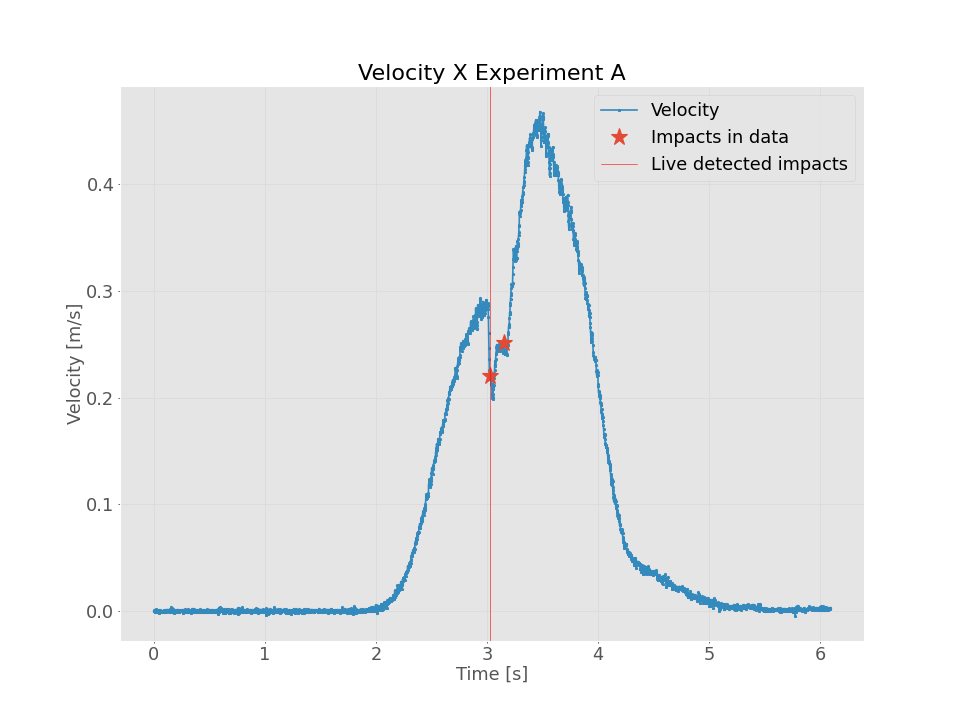

<IPython.core.display.Javascript object>


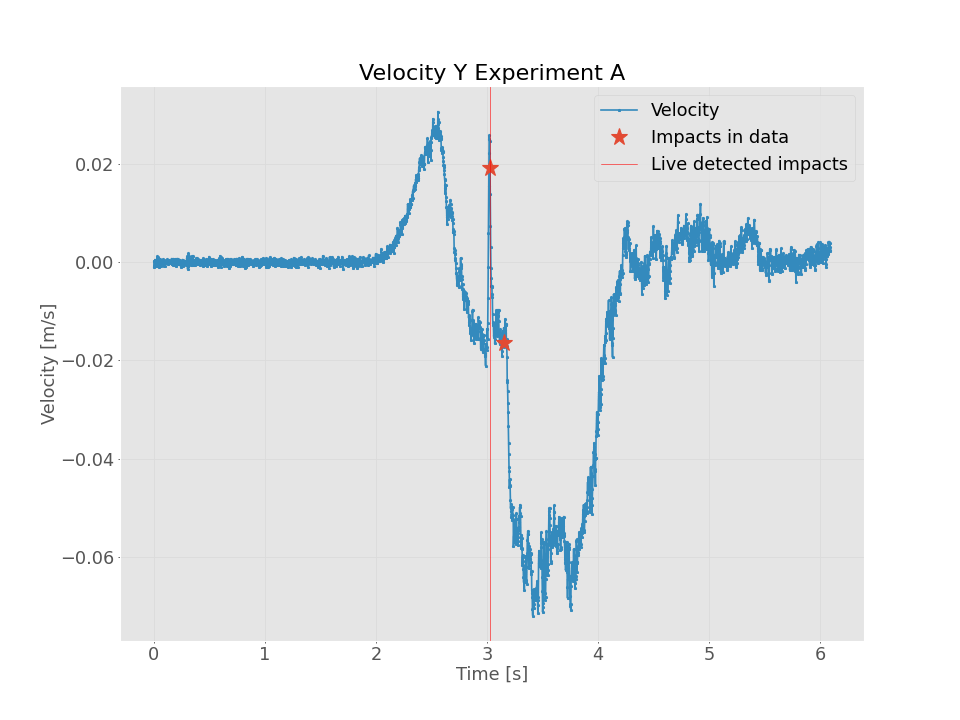

<IPython.core.display.Javascript object>


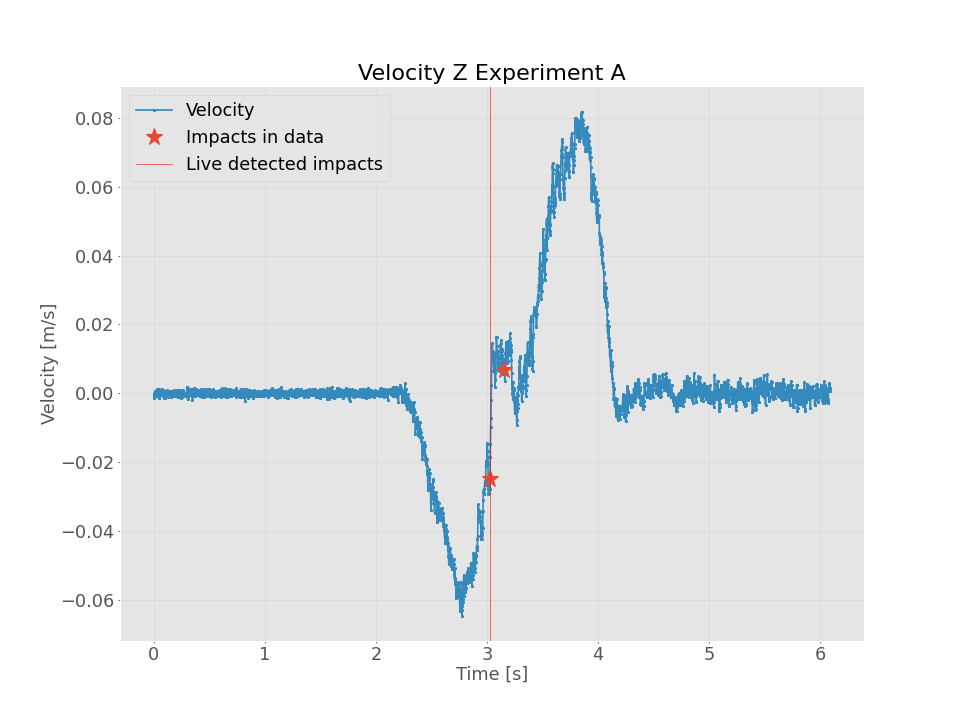

<IPython.core.display.Javascript object>


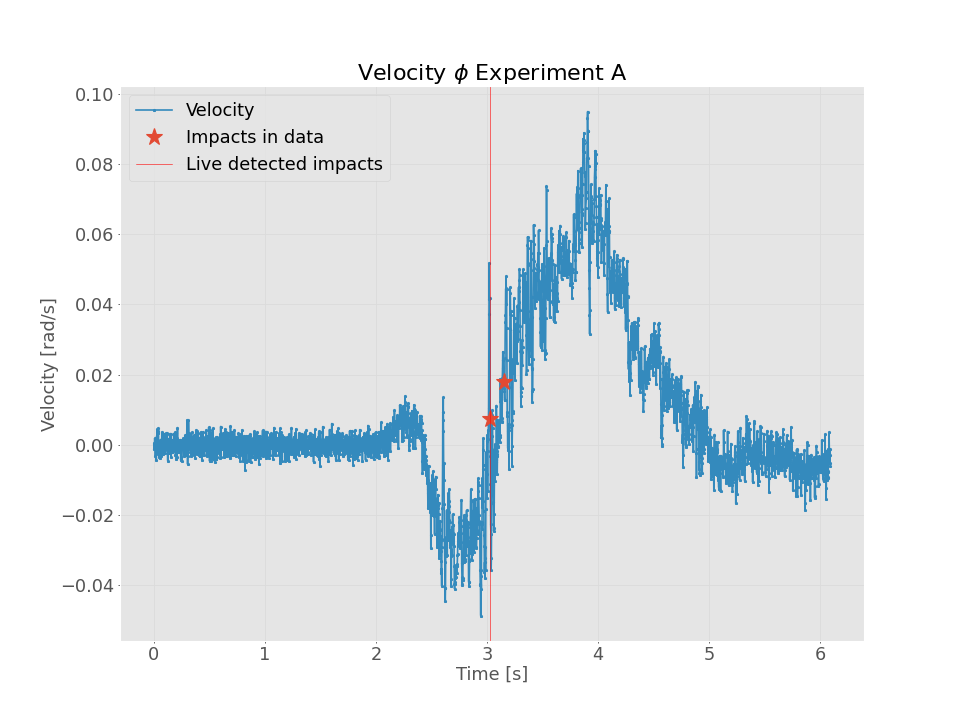

<IPython.core.display.Javascript object>


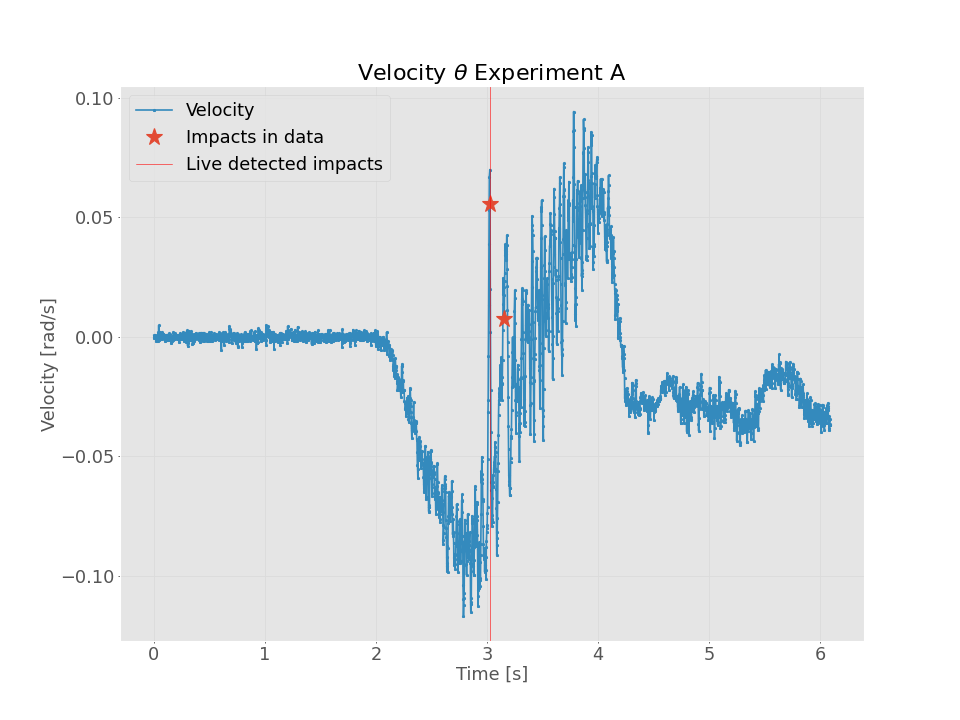

<IPython.core.display.Javascript object>


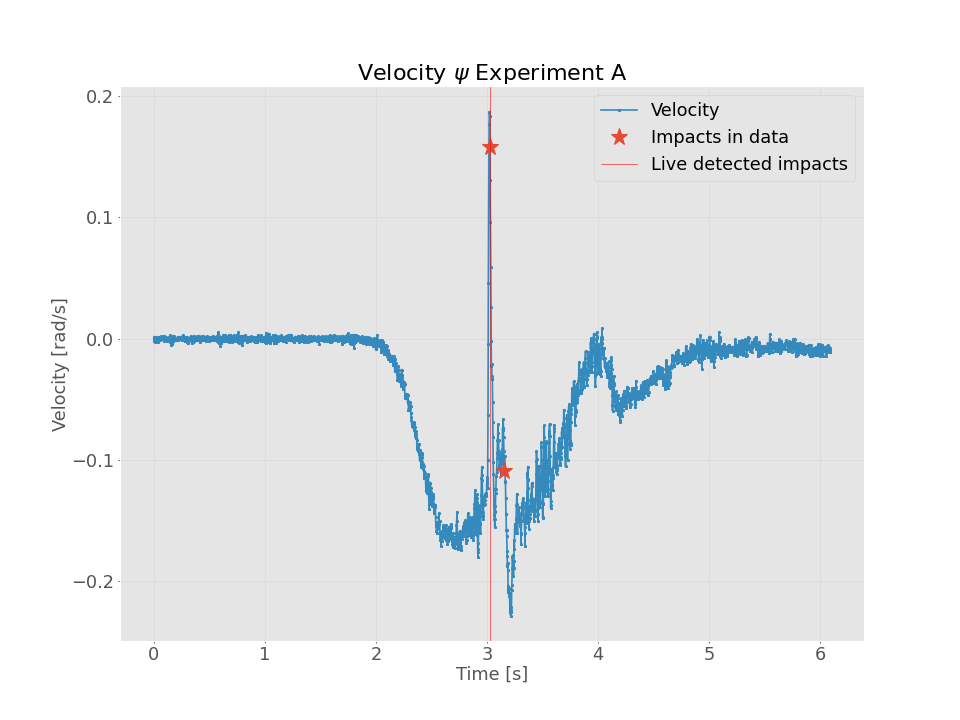

In [5]:
# Plotting velocity data

for i in range(len(config.executions)):
    filename = config.executions[i]
    data = velocity_data[i]
    imp_data = DataSet()
    for d in detected_jump_data[i]:
        if d.value:
            imp_data.append(DataPoint(d.time, 0))
    data_impacts = data[interim_phase_indices_data[i]]
    
    for k in range(2):
        
        # Pose diff data
        for j in range(3):
            fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
            plt.rcParams['xtick.labelsize'] = config.fontsize2
            plt.rcParams['ytick.labelsize'] = config.fontsize2
        
            index = 3*k+j
            plt.plot(data.time, data.get_index(index).value, f'C1-*', linewidth=config.linewidth, markersize=config.markersize3, label='Velocity')
            
            # Impacts
            impacts_data = data[impact_indices_data[i]].get_index(index)
            plt.plot(impacts_data.time, impacts_data.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Impacts in data')
    
            
            for j in imp_data.time:
                plt.axvline(x=j,color='r',label='Live detected impacts')

#             plt.axvspan(data_impacts.time[0], data_impacts.time[-1], color='C3', alpha=config.alpha, label='Interim phase')
        
            # Adding title and labels
            plt.title('Velocity ' + config.labels[index] + " " + config.titles[i],fontsize=config.fontsize1)
            plt.xlabel('Time [s]',fontsize=config.fontsize2)
            if k == 0:
                plt.ylabel('Velocity [m/s]',fontsize=config.fontsize2)
            else:
                plt.ylabel('Velocity [rad/s]',fontsize=config.fontsize2)
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
            
            if config2.xlim is not None and len(jump_indices_data[i]) > 0:
                x_min = data_impacts.time[0] + config2.xlim[0]
                x_max = data_impacts.time[-1] + config2.xlim[-1]
                plt.xlim((x_min, x_max))

<IPython.core.display.Javascript object>


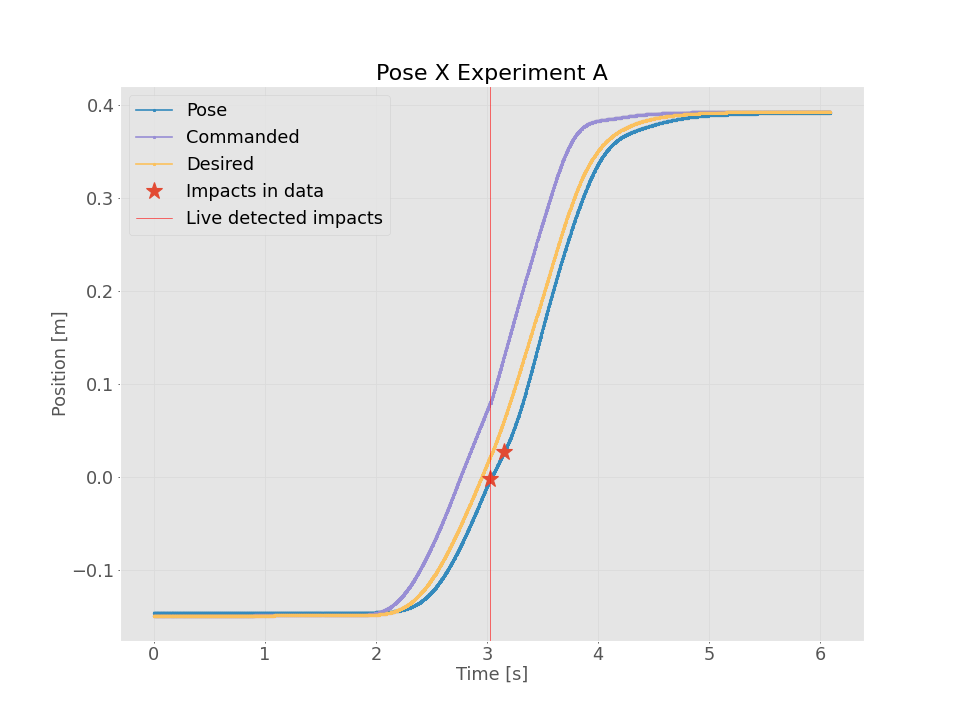

<IPython.core.display.Javascript object>


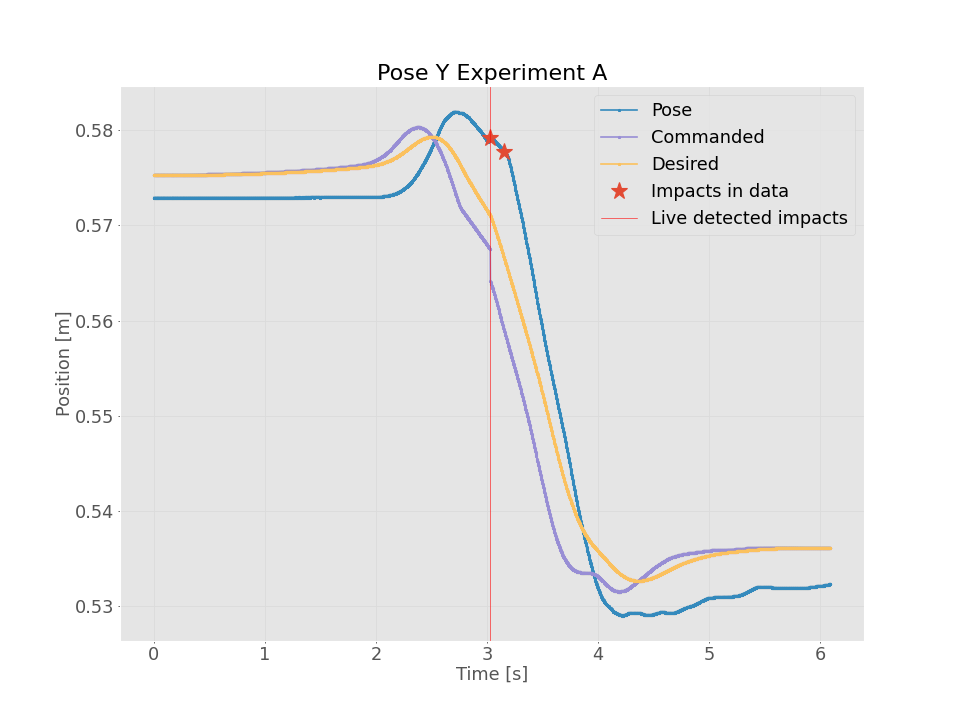

<IPython.core.display.Javascript object>


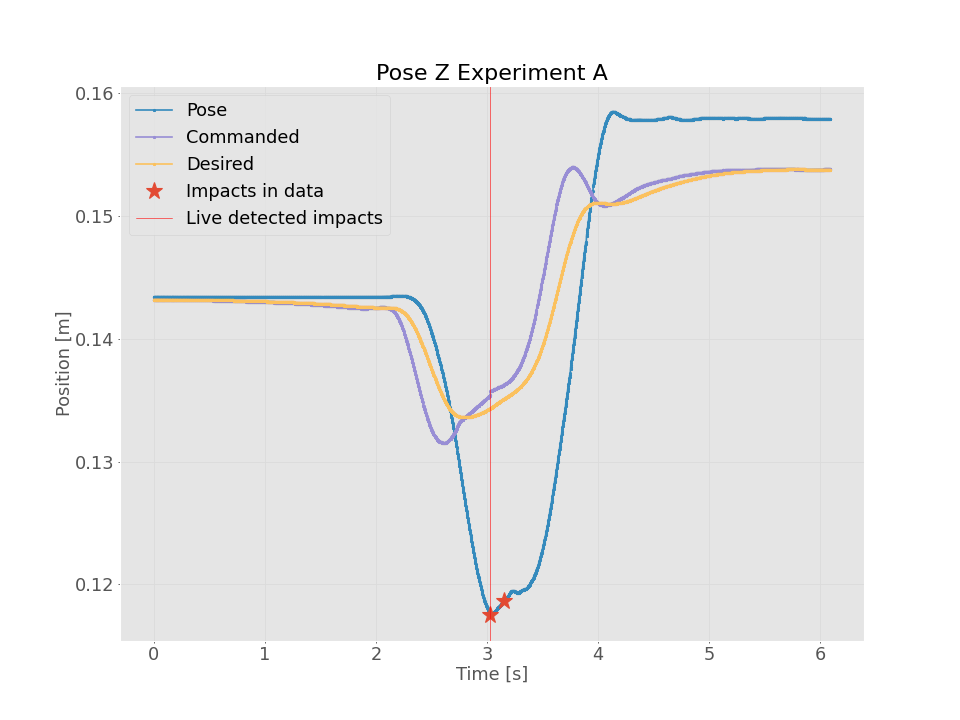

<IPython.core.display.Javascript object>


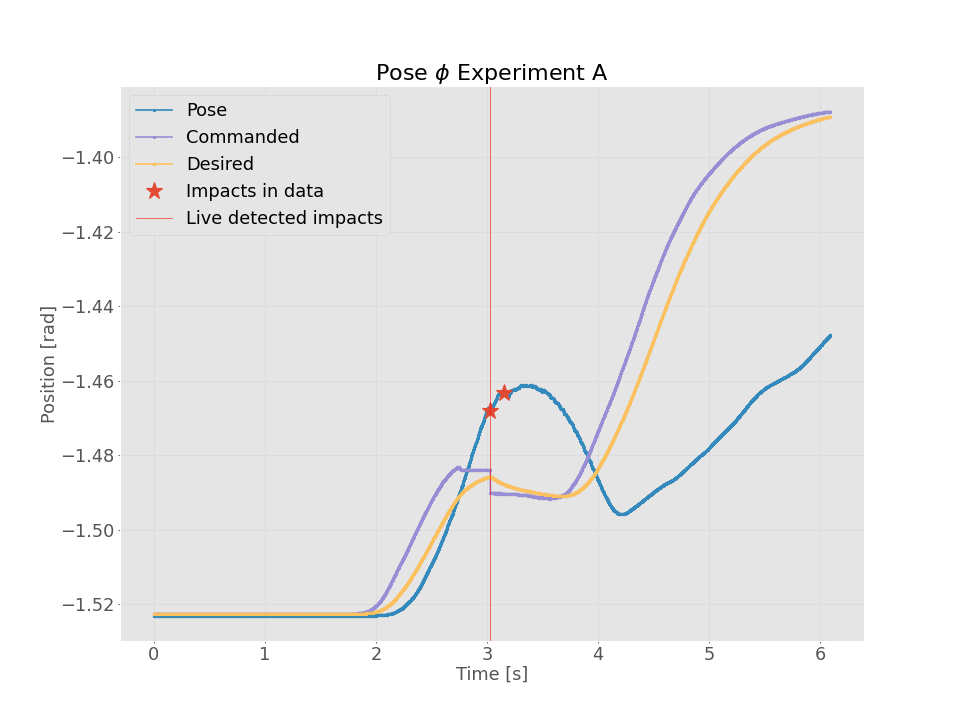

<IPython.core.display.Javascript object>


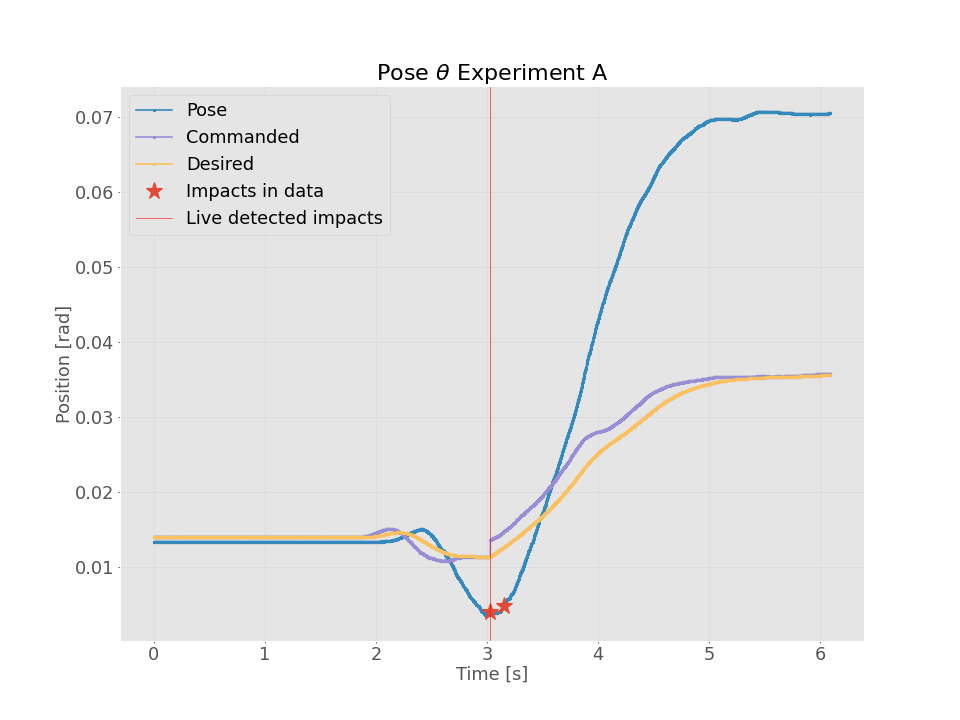

<IPython.core.display.Javascript object>


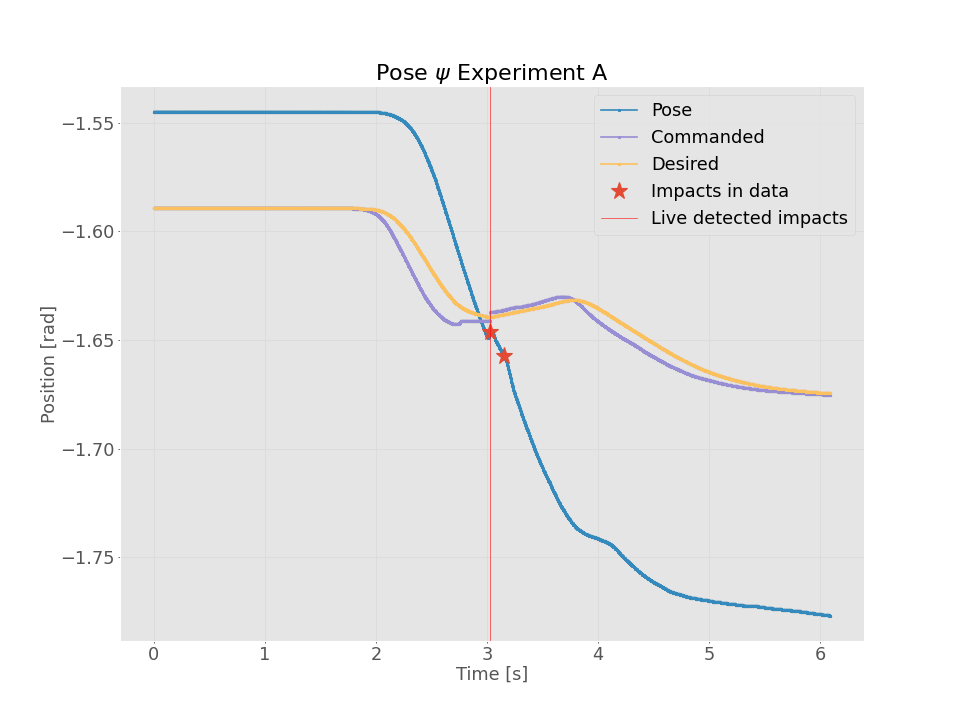

In [6]:
# Plotting pose data

for i in range(len(config.executions)):
    filename = config.executions[i]
    data = pose_data[i]
    data_c = pose_c_data[i]
    data_d = pose_d_data[i]
    
    imp_data = DataSet()
    for d in detected_jump_data[i]:
        if d.value:
            imp_data.append(DataPoint(d.time, 0))
    data_impacts = data[interim_phase_indices_data[i]]
    
    for k in range(2):
        
        labels1 = [r'$\phi$',r'$\theta$',r'$\psi$']
        labels2 = [r'$\phi_d$',r'$\theta_d$',r'$\psi_d$']

        # Pose diff data
        for j in range(3):
            fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
            plt.rcParams['xtick.labelsize'] = config.fontsize2
            plt.rcParams['ytick.labelsize'] = config.fontsize2
            
            index = 3*k+j
            plt.plot(data.time, data.get_index(index).value, f'C1-*', linewidth=config.linewidth, markersize=config.markersize3, label='Pose')
            plt.plot(data_c.time, data_c.get_index(index).value, f'C2-*', linewidth=config.linewidth, markersize=config.markersize3, label='Commanded')
            plt.plot(data_d.time, data_d.get_index(index).value, 'C4-*', linewidth=config.linewidth, markersize=config.markersize3, label='Desired')
            
            # Impacts
            impacts_data = data[impact_indices_data[i]].get_index(index)
            plt.plot(impacts_data.time, impacts_data.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Impacts in data')
            
            for j in imp_data.time:
                plt.axvline(x=j,color='r',label='Live detected impacts')

#             plt.axvspan(data_impacts.time[0], data_impacts.time[-1], color='C3', alpha=config.alpha, label='Interim phase')
    #         data_impacts = data[interim_phase_indices_data[i]]
    #         plt.plot(data_impacts.time, data_impacts.get_index(index).value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1, label='Interim phase')

            # Adding title and labels
            plt.title('Pose ' + config.labels[index] + " " + config.titles[i],fontsize=config.fontsize1)
            plt.xlabel('Time [s]',fontsize=config.fontsize2)
            if k == 0:
                plt.ylabel('Position [m]',fontsize=config.fontsize2)
            else:
                plt.ylabel('Position [rad]',fontsize=config.fontsize2)
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)

            if config2.xlim is not None and len(jump_indices_data[i]) > 0:
                x_min = data_impacts.time[0] + config2.xlim[0]
                x_max = data_impacts.time[-1] + config2.xlim[-1]
                plt.xlim((x_min, x_max))

<IPython.core.display.Javascript object>


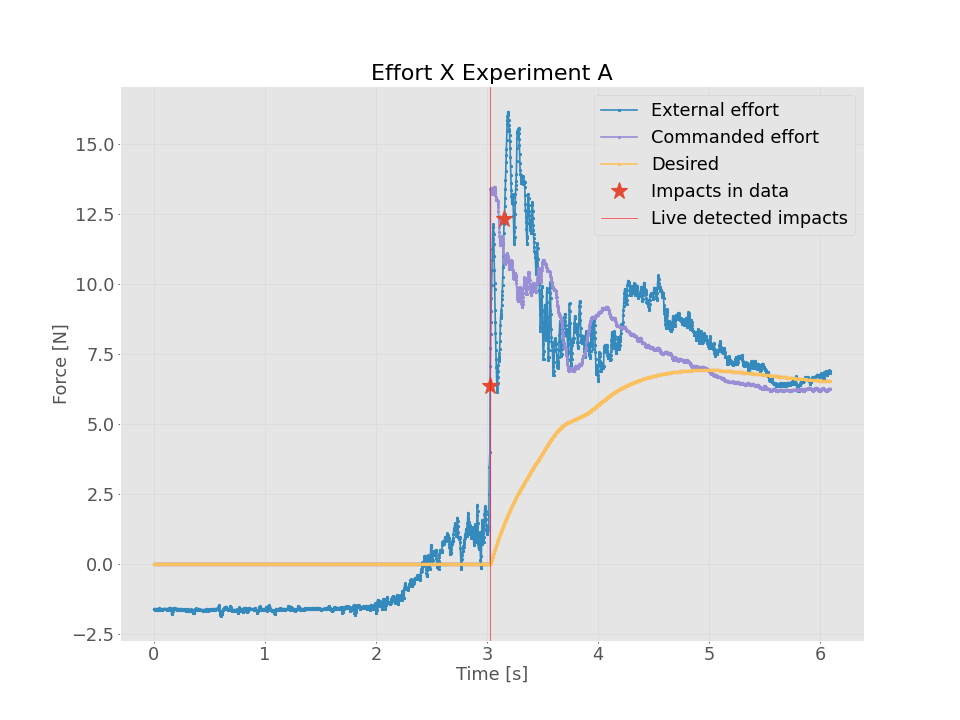

<IPython.core.display.Javascript object>


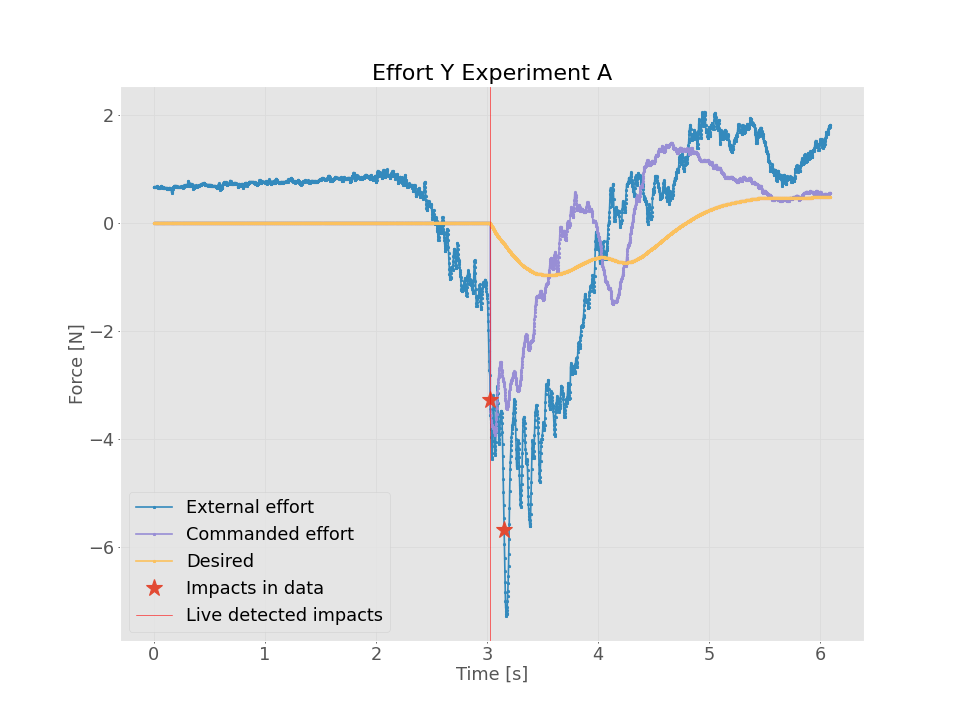

<IPython.core.display.Javascript object>


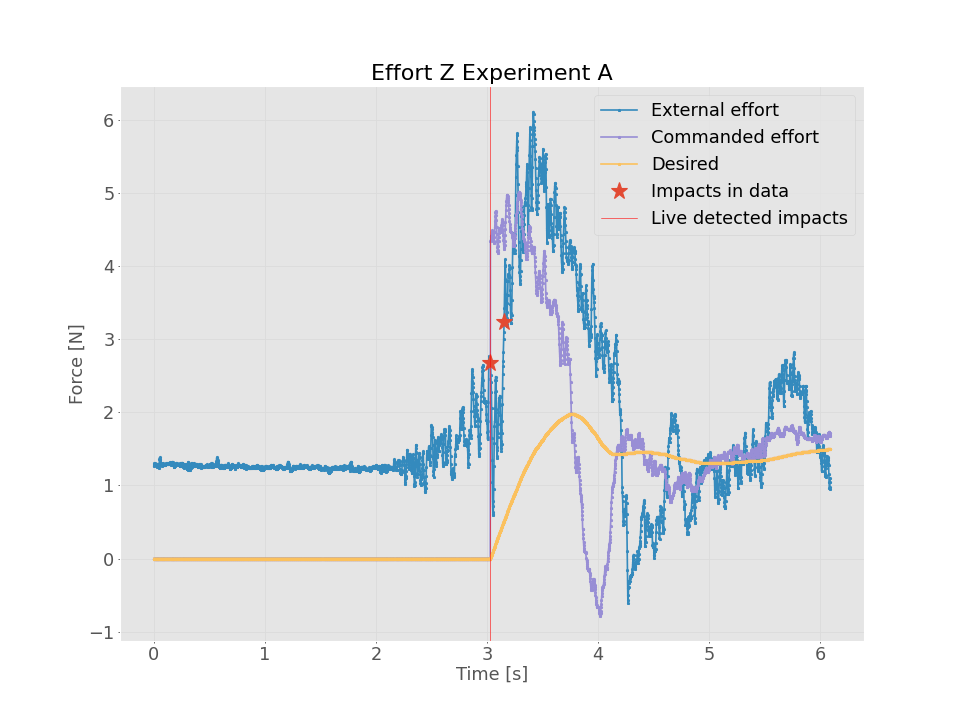

<IPython.core.display.Javascript object>


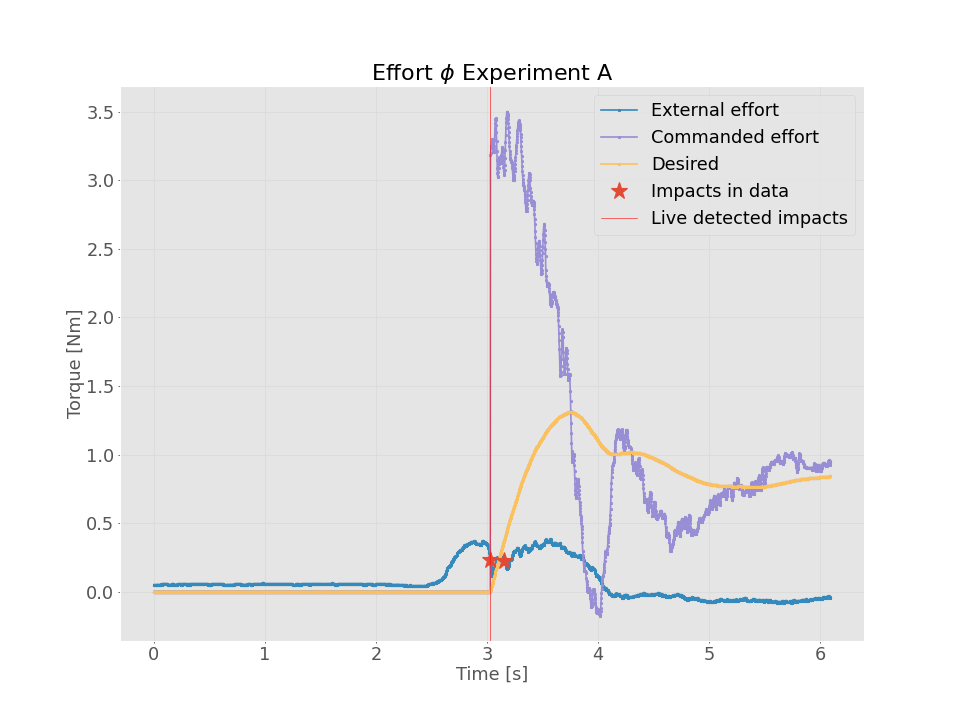

<IPython.core.display.Javascript object>


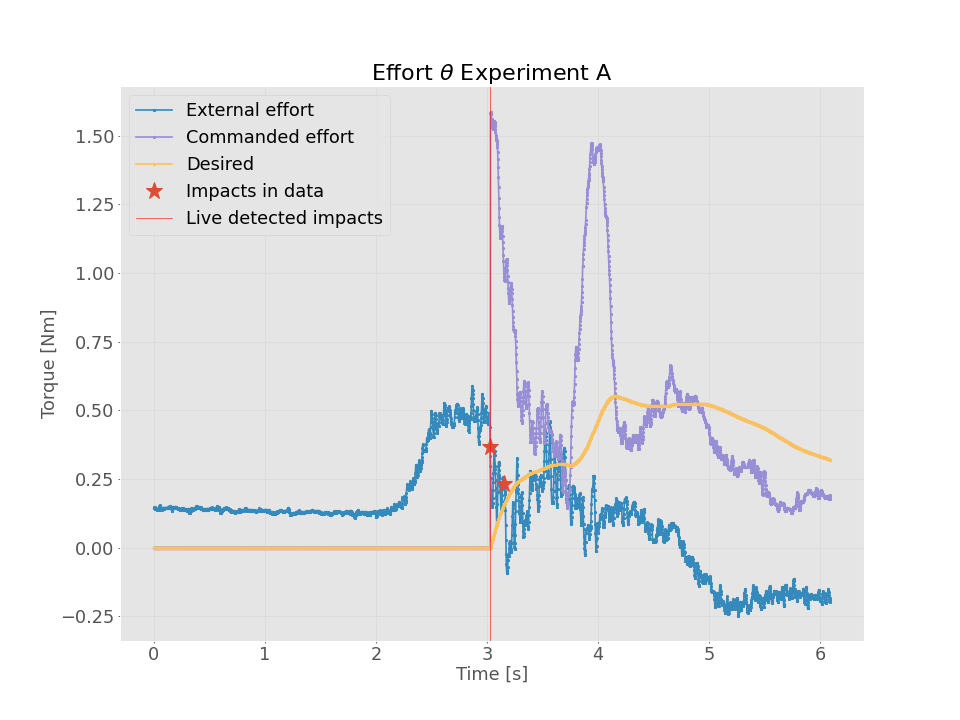

<IPython.core.display.Javascript object>


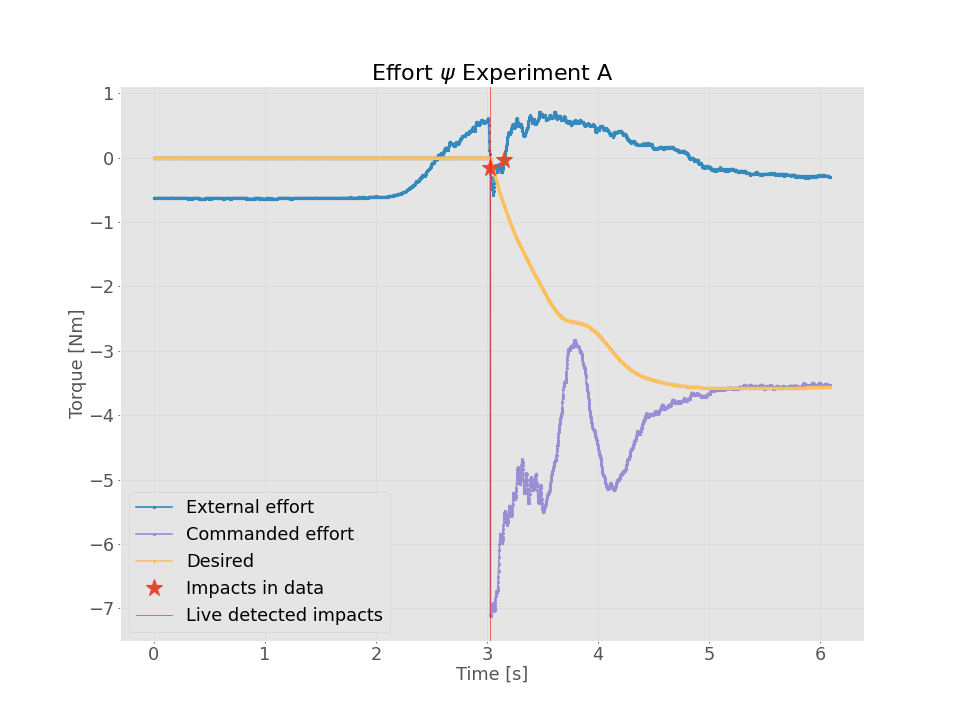

In [7]:
# Plotting effort diff data

for i in range(len(config.executions)):
    filename = config.executions[i]
    data = effort_data[i]
    data_c = effort_c_data[i]
    data_d = effort_d_data[i]
    
    imp_data = DataSet()
    for d in detected_jump_data[i]:
        if d.value:
            imp_data.append(DataPoint(d.time, 0))
    data_impacts = data[interim_phase_indices_data[i]]
    
    for k in range(2):
        

        # Pose diff data
        for j in range(3):
            
            fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
            plt.rcParams['xtick.labelsize'] = config.fontsize2
            plt.rcParams['ytick.labelsize'] = config.fontsize2
            
            index = 3*k+j
            plt.plot(data.time, data.get_index(index).value, f'C1-*', linewidth=config.linewidth, markersize=config.markersize3, label=f'External effort')
            plt.plot(data_c.time, data_c.get_index(index).value, f'C2-*', linewidth=config.linewidth, markersize=config.markersize3, label=f'Commanded effort')
            plt.plot(data_d.time, data_d.get_index(index).value, 'C4-*', linewidth=config.linewidth, markersize=config.markersize3, label='Desired')
            
            # Impacts
            impacts_data = data[impact_indices_data[i]].get_index(index)
            plt.plot(impacts_data.time, impacts_data.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Impacts in data')
            
            for j in imp_data.time:
                plt.axvline(x=j,color='r',label='Live detected impacts')

#             plt.axvspan(data_impacts.time[0], data_impacts.time[-1], color='C3', alpha=config.alpha, label='Interim phase')
            
            # Adding title and labels
            plt.title('Effort ' + config.labels[index] + " " + config.titles[i],fontsize=config.fontsize1)
            plt.xlabel('Time [s]',fontsize=config.fontsize2)
            if k == 0:
                plt.ylabel('Force [N]',fontsize=config.fontsize2)
            else:
                plt.ylabel('Torque [Nm]',fontsize=config.fontsize2)
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
            
            if config2.xlim is not None and len(jump_indices_data[i]) > 0:
                x_min = data_impacts.time[0] + config2.xlim[0]
                x_max = data_impacts.time[-1] + config2.xlim[-1]
                plt.xlim((x_min, x_max))

<IPython.core.display.Javascript object>


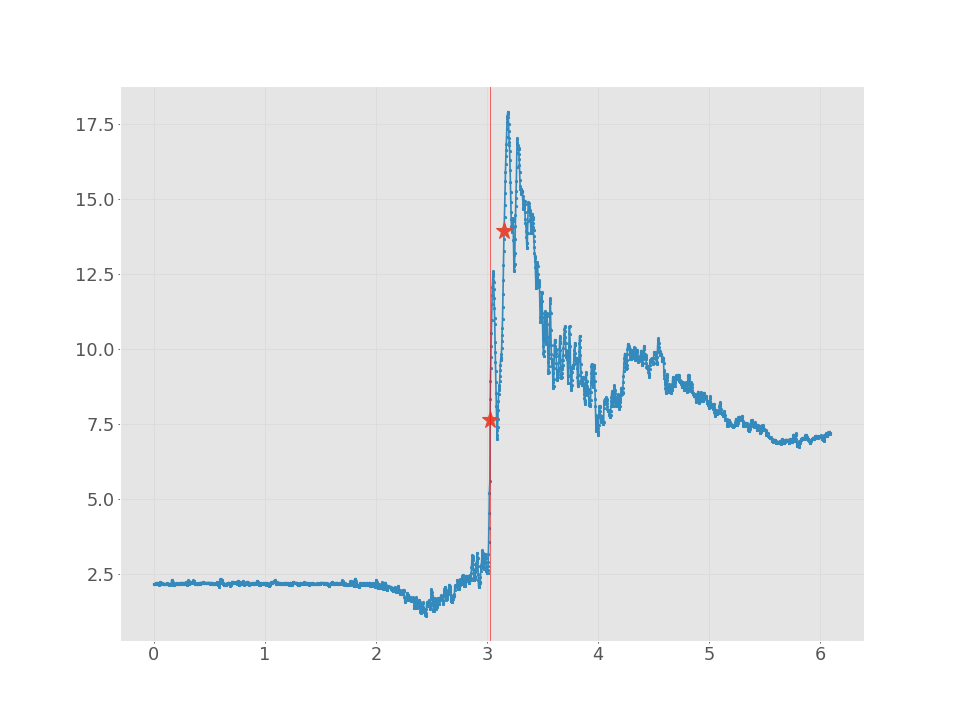

IndexError: list index out of range

In [8]:
# Plotting external force data

for i in range(len(config.executions)):
    filename = config.executions[i]
    data = force_ext[i]
    
    imp_data = DataSet()
    for d in detected_jump_data[i]:
        if d.value:
            imp_data.append(DataPoint(d.time, 0))
    data_impacts = data[interim_phase_indices_data[i]]
    
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

    # Pose diff data
    plt.plot(data.time, data.value, f'C1-*', linewidth=config.linewidth, markersize=config.markersize3, label=f'External force')
    
#     plt.plot(data_impacts.time, data_impacts.value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1, label='Interim phase')
    force_ext_impacts = data[impact_indices_data[i]]
    plt.plot(force_ext_impacts.time, force_ext_impacts.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Impacts in data')
    
    for j in imp_data.time:
        plt.axvline(x=j,color='r',label='Live detected impacts')
        
    plt.axvspan(data_impacts.time[0], data_impacts.time[-1], color='C3', alpha=config.alpha, label='Interim phase')
    
    # Adding title and labels
    plt.title('External force magnitude ' + config.titles[i],fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Force [N]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
    
    if config2.xlim is not None and len(jump_indices_data[i]) > 0:
        x_min = data_impacts.time[0] + config2.xlim[0]
        x_max = data_impacts.time[-1] + config2.xlim[-1]
        plt.xlim((x_min, x_max))

In [ ]:
# Plotting derivative external force data

for i in range(len(config.executions)):
    demo = config.executions[i]
#     data = force_ext_vec[i].diff.mag
    data = abs(force_ext_vec2[i].diff.get_index(2))    
    data_time = abs(force_ext_vec[i].diff.get_index(2))
    
    imp_data = DataSet()
    for d in detected_jump_data[i]:
        if d.value:
            imp_data.append(DataPoint(d.time, 0))
    data_impacts = data[interim_phase_indices_data[i]]
    
    ## Plot external force
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2
    
    # External force data
    plt.plot(data_time.time, data.value, f'C1-*', linewidth=config.linewidth, markersize=config.markersize2, label='External force magnitude')

    # Jumps and impacts
#     force_ext_jumps = data[jump_indices_data[i]]
#     force_ext_jumps_time = data_time[jump_indices_data[i]]
#     plt.plot(force_ext_jumps_time.time, force_ext_jumps.value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected jumps')
    force_ext_impacts = data[impact_indices_data[i]]
    force_ext_impacts_time = data_time[impact_indices_data[i]]
    plt.plot(force_ext_impacts_time.time, force_ext_impacts.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Impacts in data')
    
    for j in imp_data.time:
        plt.axvline(x=j,color='r',label='Live detected impacts')
        
    plt.axvspan(data_impacts.time[0], data_impacts.time[-1], color='C3', alpha=config.alpha, label='Interim phase')
    
    # Adding title and labels
    plt.title('External force rate ' + config.titles[i],fontsize=config.fontsize1)
#     plt.title('External force magnitude data ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Force rate [N/s]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
    if config2.xlim is not None and len(jump_indices_data[i]) > 0:
        x_min = data_impacts.time[0] + config2.xlim[0]
        x_max = data_impacts.time[-1] + config2.xlim[-1]
        plt.xlim((x_min, x_max))

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]


<IPython.core.display.Javascript object>


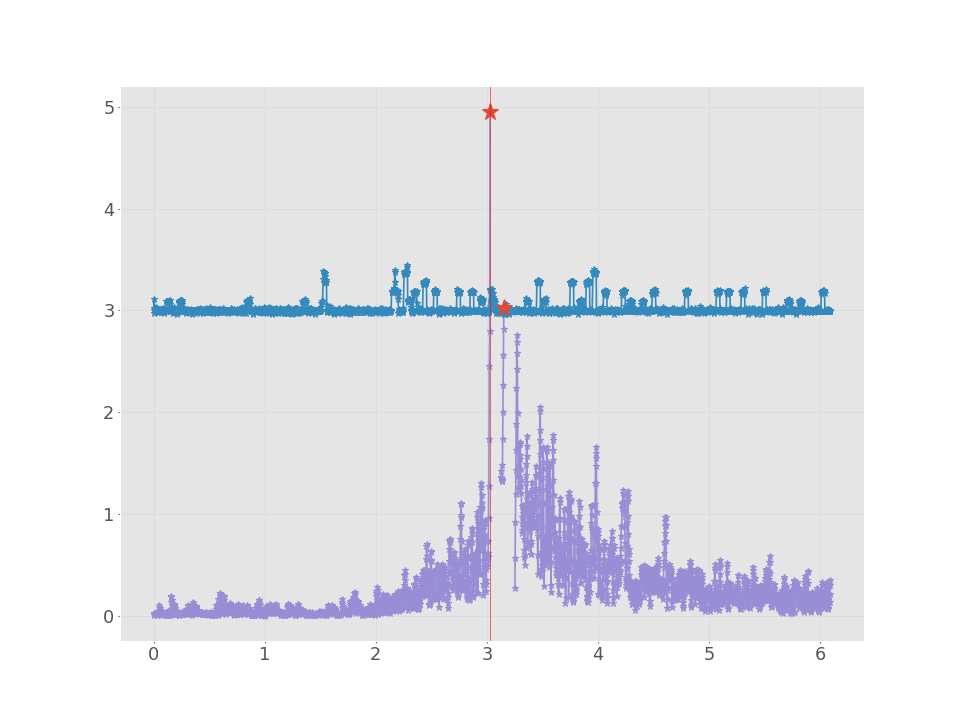

IndexError: list index out of range

In [9]:
# Plot difference between data and prediction

for i in range(len(config.executions)):
    demo = config.executions[i]
    data = force_ext_vec[i]
    
    predictions = PositionDataSet.from_dataset(predictions_data[i])
    pred_diff = (data - predictions).mag
    
    imp_data = DataSet()
    for d in detected_jump_data[i]:
        if d.value:
            imp_data.append(DataPoint(d.time, 0))
    
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

    # Difference between data and prediction
    plt.plot(pred_diff.time, pred_diff.value, 'C2-*', linewidth=config.linewidth, markersize=config.markersize2, label='Difference')
#     pred_diff_jumps = pred_diff[[index for index in jump_indices_data[i]]]
#     plt.plot(pred_diff_jumps.time, pred_diff_jumps.value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1,label='Detected jumps')
    
    # Bound
    plt.plot(data.time, bounds_data[i].value, 'C1-*', linewidth=config.linewidth, markersize=config.markersize2, label='Bound')
    
    pred_diff_impacts = pred_diff[[index for index in impact_indices_data[i]]]
    plt.plot(pred_diff_impacts.time, pred_diff_impacts.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1,label='Impacts in data')
    
    for j in imp_data.time:
        plt.axvline(x=j,color='r',label='Live detected impacts')
        
    plt.axvspan(data_impacts.time[0], data_impacts.time[-1], color='C3', alpha=config.alpha, label='Interim phase')
    
    # Adding title and labels
    plt.title('Difference between external force magnitude data and predictions ' + config.titles[i],fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Force [N]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
    if config2.xlim is not None and len(jump_indices_data[i]) > 0:
        x_min = data_impacts.time[0] + config2.xlim[0]
        x_max = data_impacts.time[-1] + config2.xlim[-1]
        plt.xlim((x_min, x_max))

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]


In [ ]:
# Save all figures in pdf file

def multipage(filename, figs=None):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp, dpi=config.dpi, format='pdf')
    pp.close()
    
if config2.xlim is not None:
    multipage(config.output_plot_all_zoom)
else:
    multipage(config.output_plot_all)
    